In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#For loading data set directy from the repo
from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

#Importing knn.py from the same folder
from knn import knn_predict

# --- 1) Load Wine dataset ---
wine = fetch_ucirepo(id=109)
X_full = wine.data.features
y_full = wine.data.targets

# Check if there's any null (missing) data
print("Null values in each column:\n", X_full.isnull().sum())

# Ensure y_full is 1D
if hasattr(y_full, 'values'):
    y_full = y_full.values
y_full = y_full.ravel()


Null values in each column:
 Alcohol                         0
Malicacid                       0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
0D280_0D315_of_diluted_wines    0
Proline                         0
dtype: int64


In [43]:
# --- 2) Select top 6 features  ---
selector = SelectKBest(score_func=f_classif, k=6)
X_selected = selector.fit_transform(X_full, y_full)

all_feature_names = list(X_full.columns)
chosen_indices = selector.get_support(indices=True)
chosen_feature_names = [all_feature_names[i] for i in chosen_indices]
print("\nSelected features:", chosen_feature_names)


Selected features: ['Alcohol', 'Flavanoids', 'Color_intensity', 'Hue', '0D280_0D315_of_diluted_wines', 'Proline']


In [44]:
# --- 3) Normalize (MinMax) ---
X_min = X_selected.min(axis=0)
X_max = X_selected.max(axis=0)
X_norm = (X_selected - X_min) / (X_max - X_min)

# Convert to DataFrame for plotting
X_norm_df = pd.DataFrame(X_norm, columns=chosen_feature_names)
df_plot = X_norm_df.copy()
df_plot['Class'] = y_full

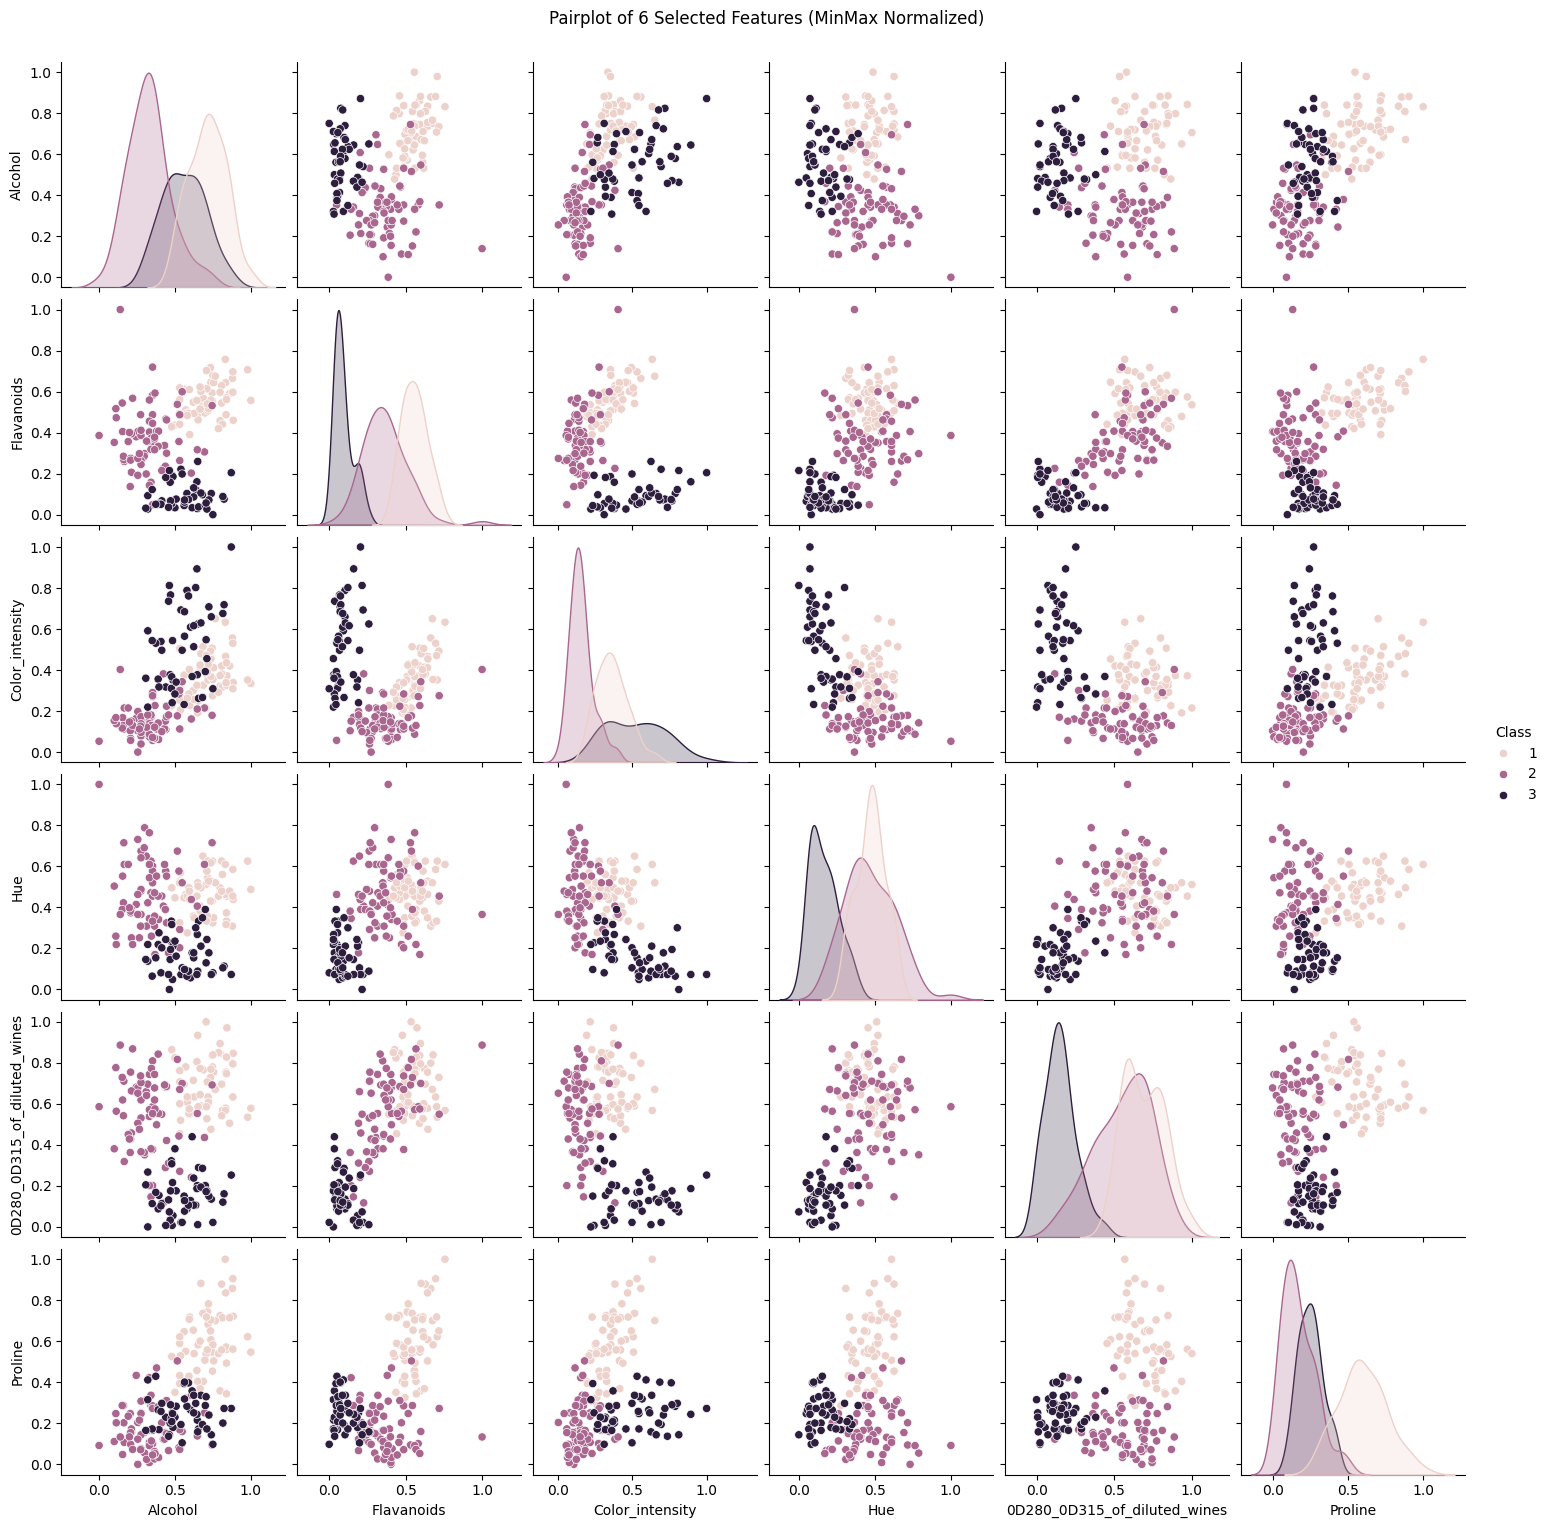

In [45]:
# --- 4) Pair to see distribution among selected features ---
sns.pairplot(df_plot, vars=chosen_feature_names, hue='Class', diag_kind='kde')
plt.suptitle("Pairplot of 6 Selected Features (MinMax Normalized)", y=1.02)
plt.show()

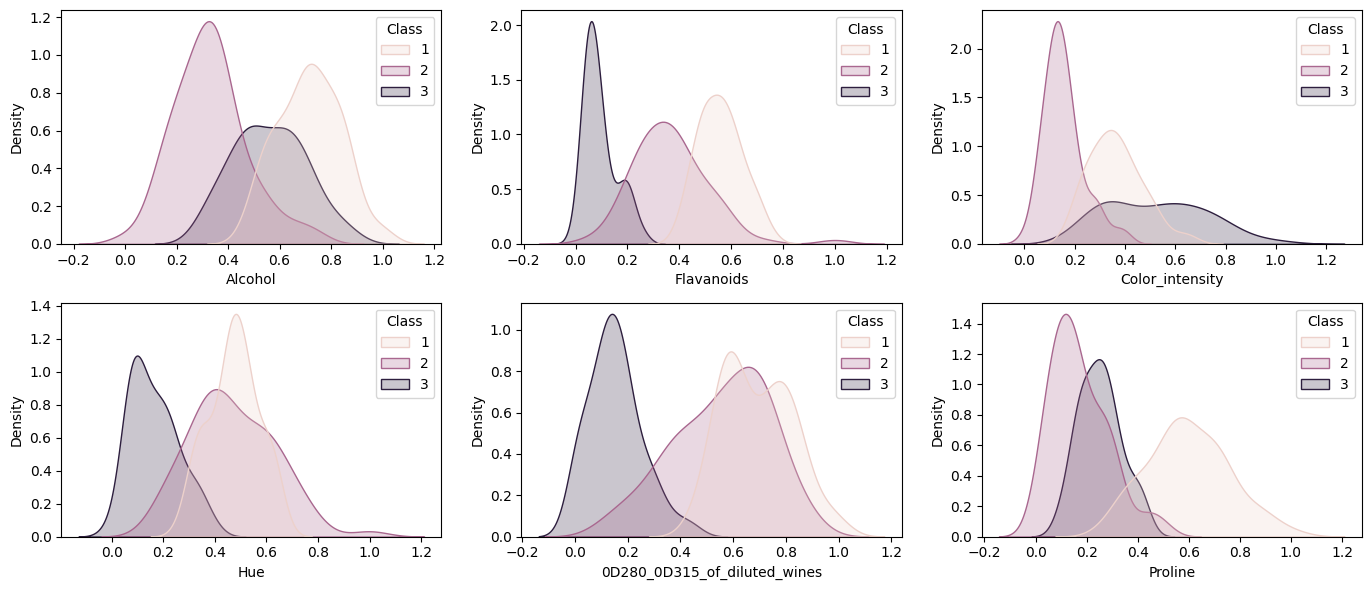

In [46]:
# --- 5)KDE plots (2x3) for each selected feature ---
num_feats = len(chosen_feature_names)
rows, cols = 2, 3
fig, axs = plt.subplots(rows, cols, figsize=(14, 6))

for i, feat in enumerate(chosen_feature_names):
    r = i // cols
    c = i % cols
    ax = axs[r][c]
    sns.kdeplot(data=df_plot, x=feat, hue='Class', fill=True, ax=ax)
    ax.set_title('')
plt.tight_layout()
plt.show()

In [47]:
# --- 6) Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_norm,
    y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

In [48]:
# --- 7) Compare custom (Euclidian & Manhattan) + built-in (Euclidian & Manhattan) ---
k_values = [1, 2, 3, 4, 5, 6, 7]

acc_custom_euclid = []
acc_custom_manhat = []
acc_builtin_euclid = []
acc_builtin_manhat = []

for k in k_values:
    # Custom Euclidean
    y_pred_ce = knn_predict(X_train, y_train, X_test, k, 'euclidean')
    acc_ce = np.mean(y_pred_ce == y_test)
    acc_custom_euclid.append(acc_ce)

    # Custom Manhattan
    y_pred_cm = knn_predict(X_train, y_train, X_test, k, 'manhattan')
    acc_cm = np.mean(y_pred_cm == y_test)
    acc_custom_manhat.append(acc_cm)

    # Built-in Euclidean
    knn_euclid = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn_euclid.fit(X_train, y_train)
    y_pred_be = knn_euclid.predict(X_test)
    acc_be = np.mean(y_pred_be == y_test)
    acc_builtin_euclid.append(acc_be)

    # Built-in Manhattan
    knn_manhat = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn_manhat.fit(X_train, y_train)
    y_pred_bm = knn_manhat.predict(X_test)
    acc_bm = np.mean(y_pred_bm == y_test)
    acc_builtin_manhat.append(acc_bm)

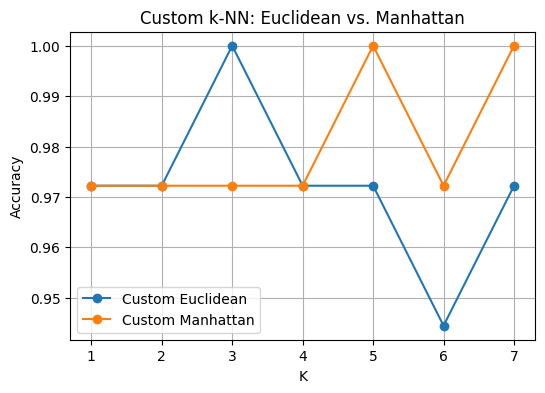

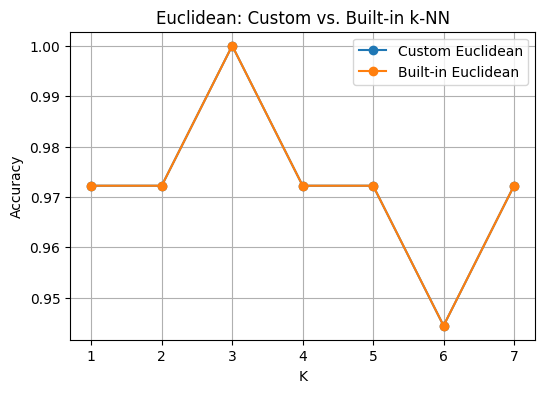

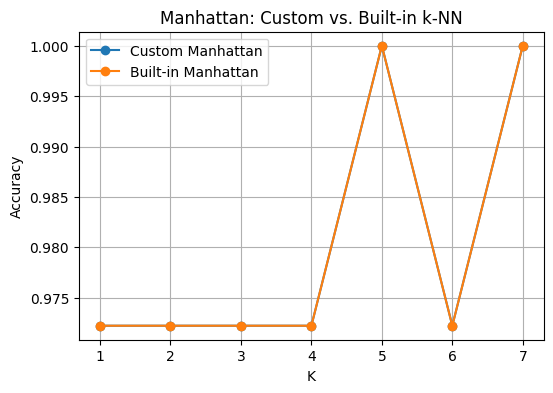

In [49]:
# --- 8) Accuracy vs. K plots ---

# (A) Custom Euclidean vs. Custom Manhattan
plt.figure(figsize=(6, 4))
plt.plot(k_values, acc_custom_euclid, '-o', label="Custom Euclidean")
plt.plot(k_values, acc_custom_manhat, '-o', label="Custom Manhattan")
plt.title("Custom k-NN: Euclidean vs. Manhattan")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

# (B) Custom Euclidean vs. Built-in Euclidean
plt.figure(figsize=(6, 4))
plt.plot(k_values, acc_custom_euclid, '-o', label="Custom Euclidean")
plt.plot(k_values, acc_builtin_euclid, '-o', label="Built-in Euclidean")
plt.title("Euclidean: Custom vs. Built-in k-NN")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

# (C) Custom Manhattan vs. Built-in Manhattan
plt.figure(figsize=(6, 4))
plt.plot(k_values, acc_custom_manhat, '-o', label="Custom Manhattan")
plt.plot(k_values, acc_builtin_manhat, '-o', label="Built-in Manhattan")
plt.title("Manhattan: Custom vs. Built-in k-NN")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# --- 9) Confusion Matrices & Classification Reports for every k in [1..7]
#     We'll produce 4 subplots per k:
#     (1) Custom Euclidean, (2) Custom Manhattan, (3) Built-in Euclidean, (4) Built-in Manhattan.
#     That means 28 total figures (7 values of k × 4 approaches).


--- k=1, Custom Euclidean ---
Classification Report:
               precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36

--- k=1, Custom Manhattan ---
Classification Report:
               precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36

--- k=1, Built-in Euclidean ---
Classification Report:
               precision    recall  f1-score   support

           1      

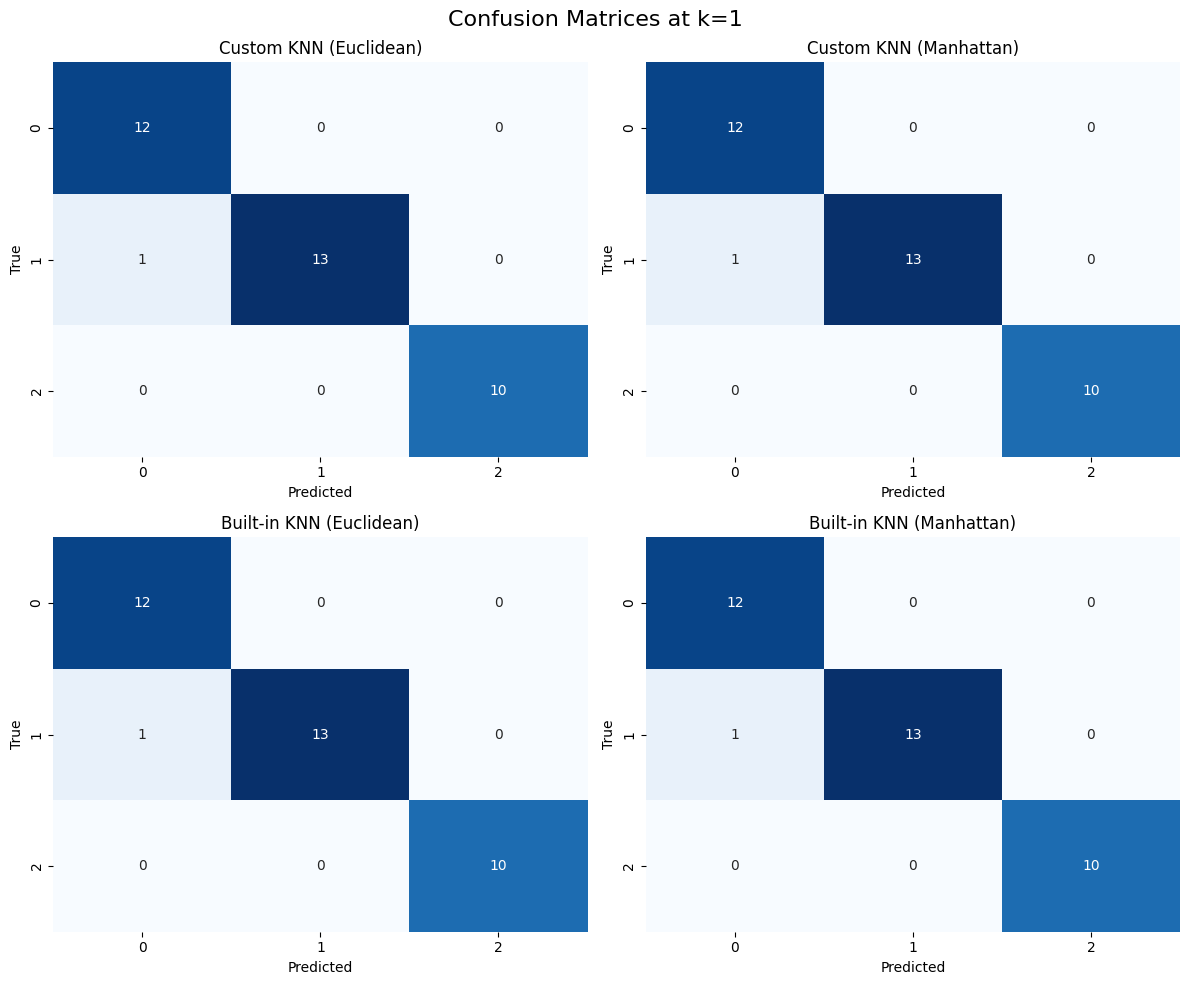


--- k=2, Custom Euclidean ---
Classification Report:
               precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36

--- k=2, Custom Manhattan ---
Classification Report:
               precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36

--- k=2, Built-in Euclidean ---
Classification Report:
               precision    recall  f1-score   support

           1      

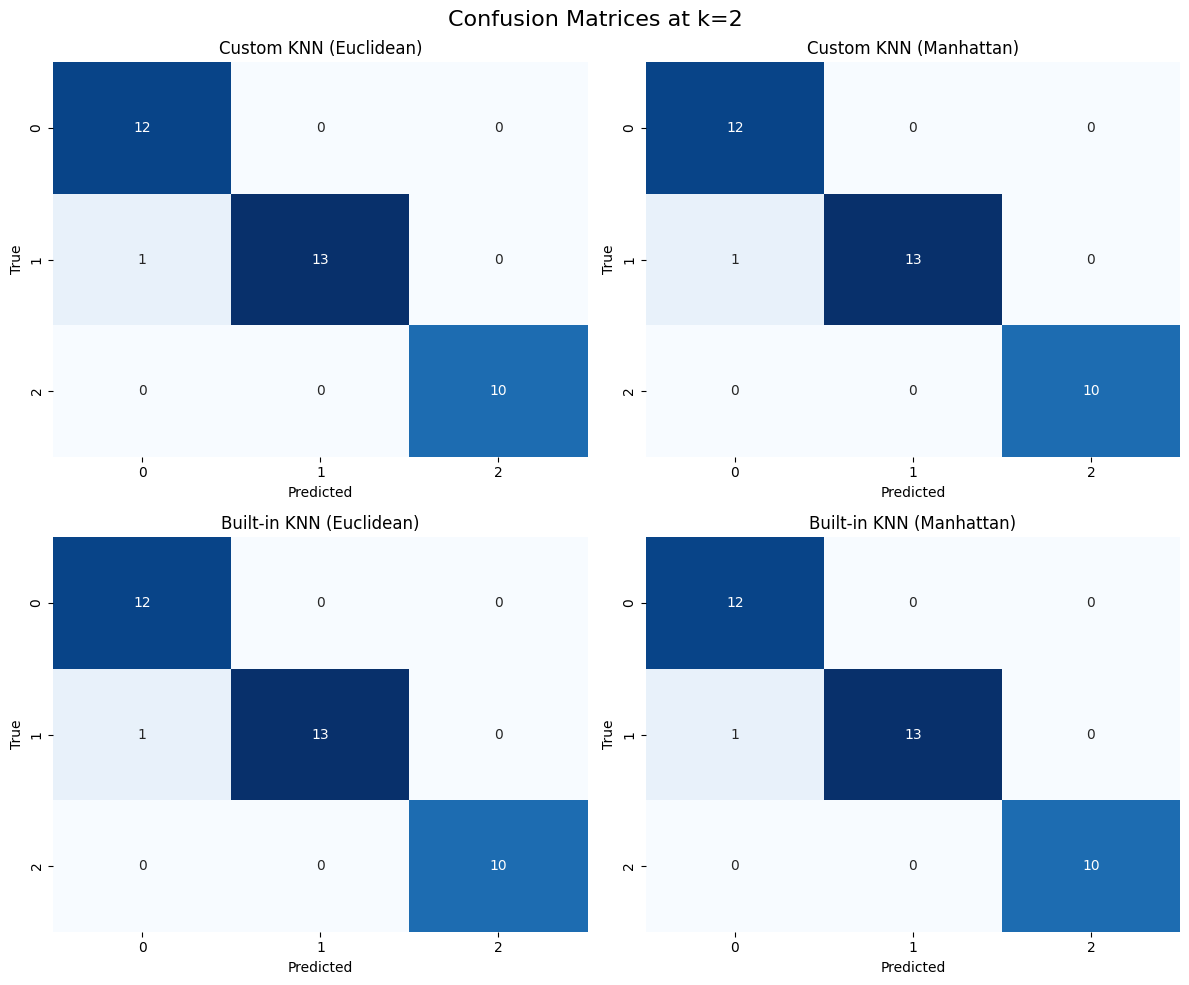


--- k=3, Custom Euclidean ---
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

--- k=3, Custom Manhattan ---
Classification Report:
               precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36

--- k=3, Built-in Euclidean ---
Classification Report:
               precision    recall  f1-score   support

           1      

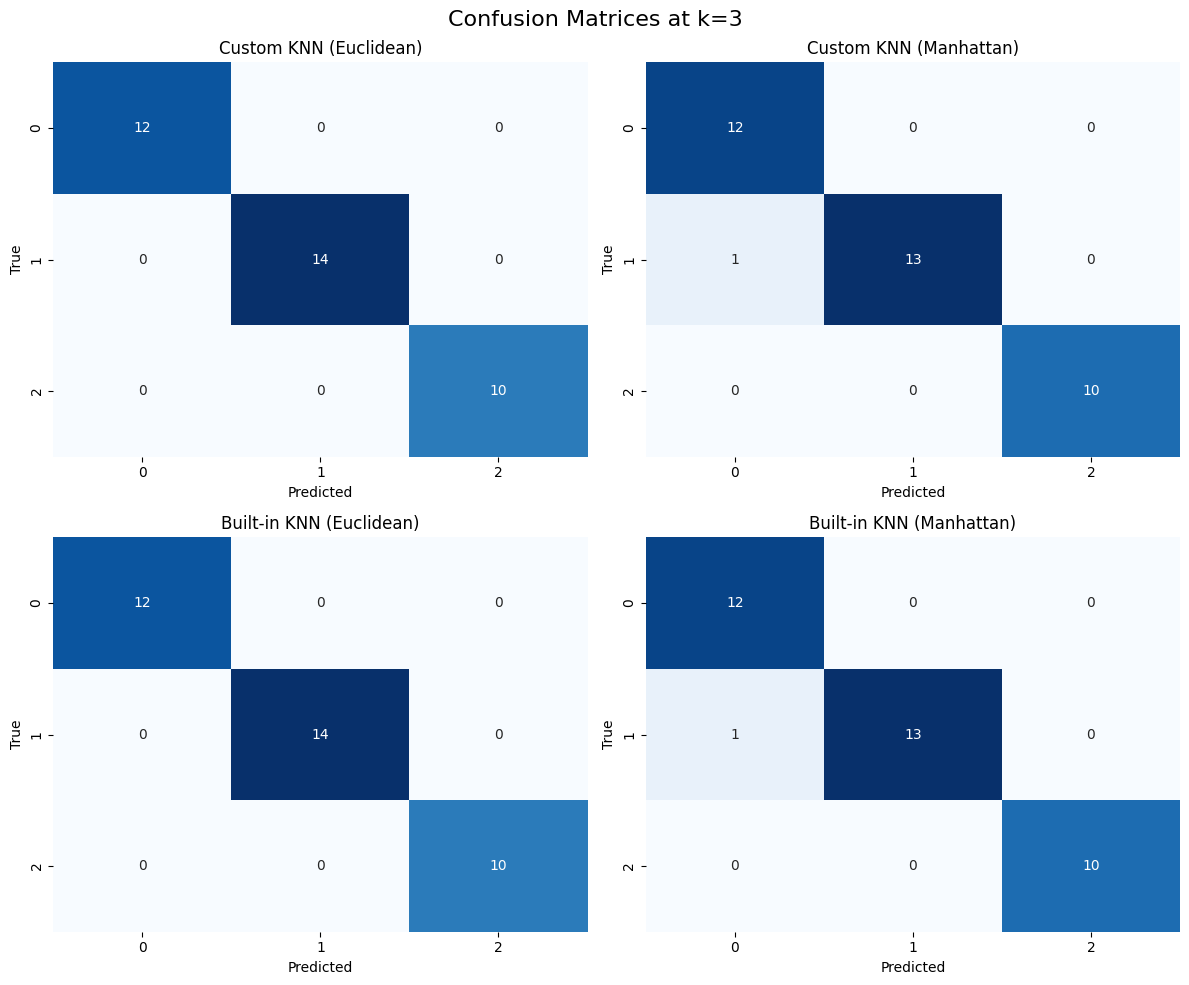


--- k=4, Custom Euclidean ---
Classification Report:
               precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36

--- k=4, Custom Manhattan ---
Classification Report:
               precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36

--- k=4, Built-in Euclidean ---
Classification Report:
               precision    recall  f1-score   support

           1      

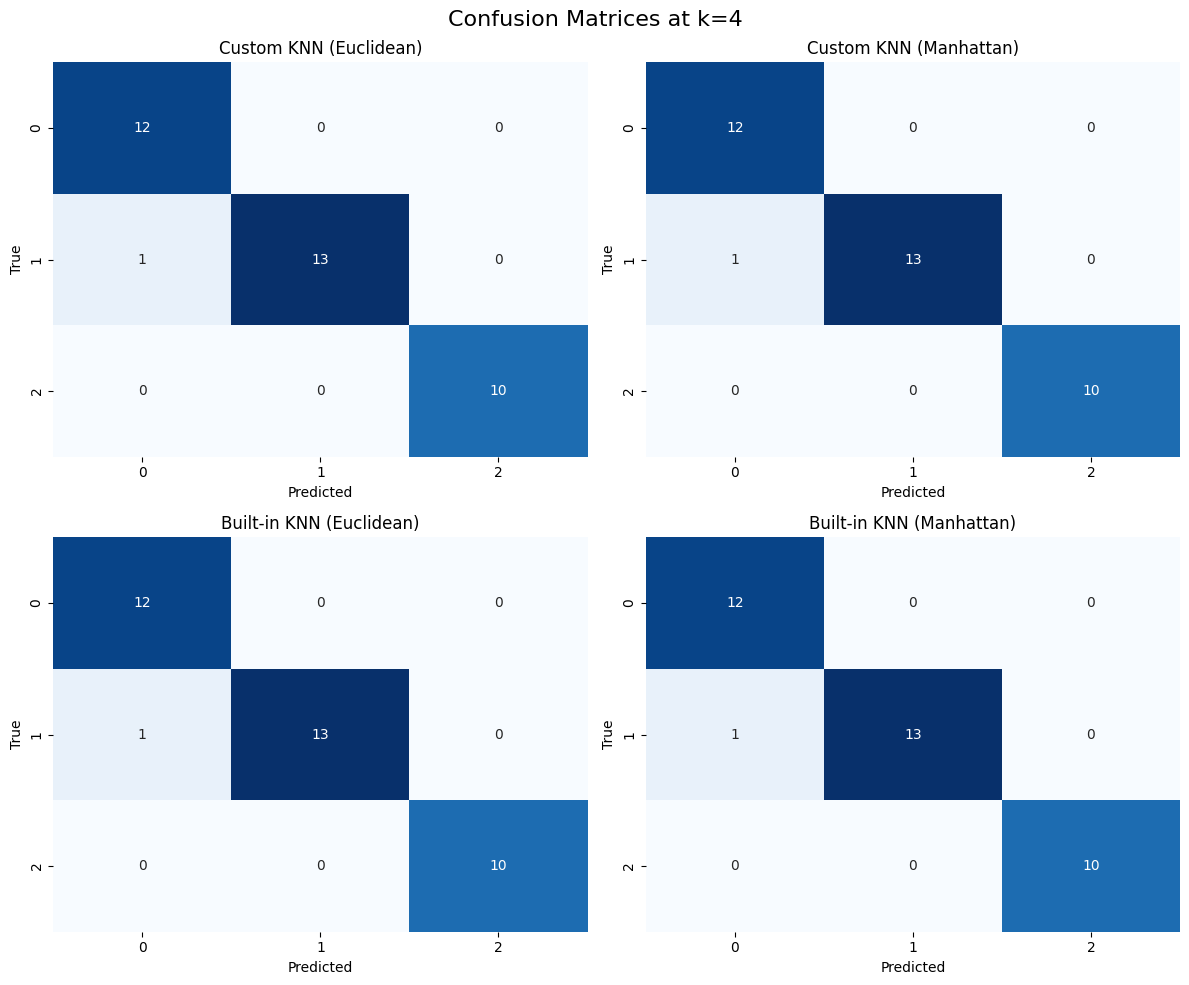


--- k=5, Custom Euclidean ---
Classification Report:
               precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36

--- k=5, Custom Manhattan ---
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

--- k=5, Built-in Euclidean ---
Classification Report:
               precision    recall  f1-score   support

           1      

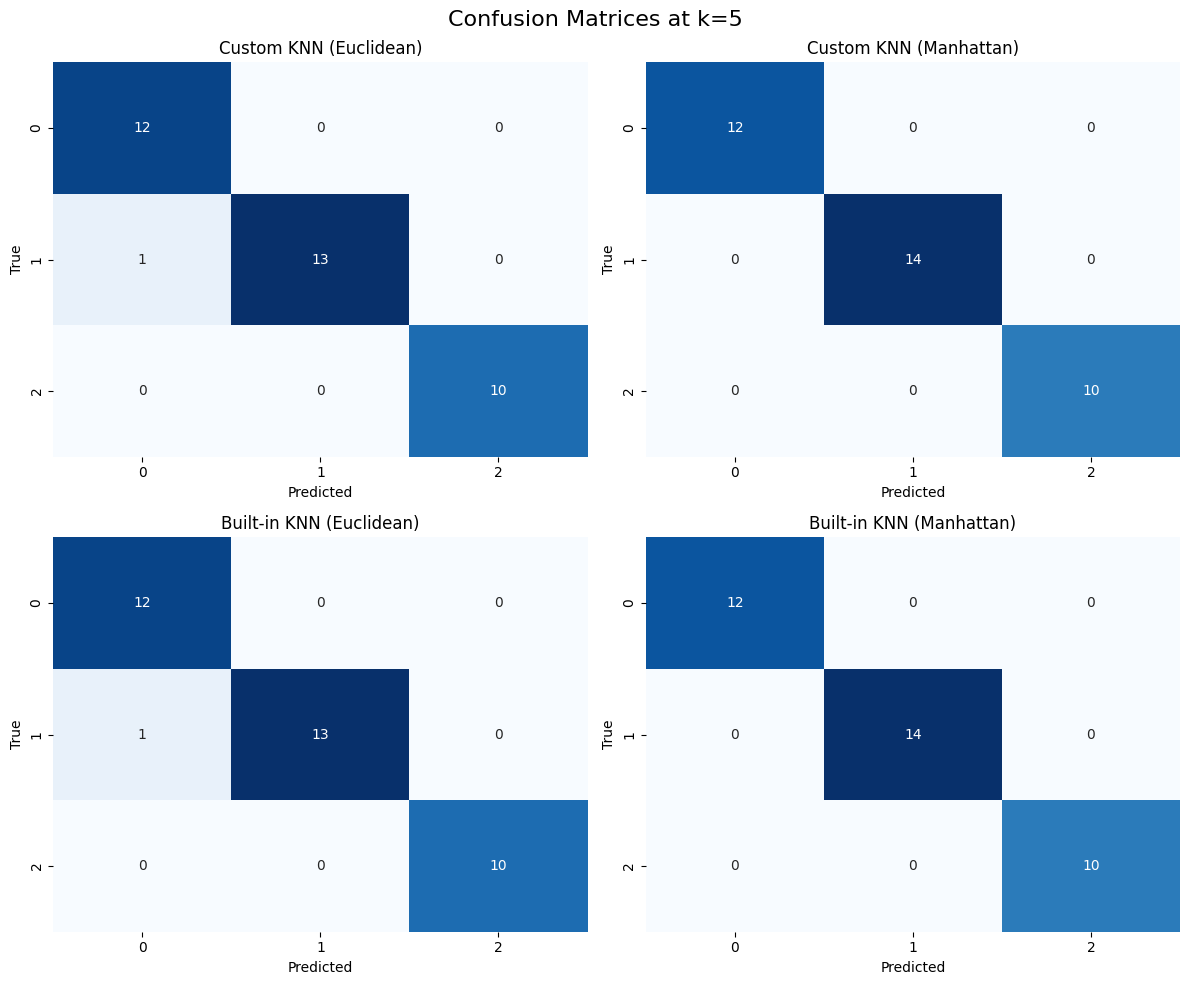


--- k=6, Custom Euclidean ---
Classification Report:
               precision    recall  f1-score   support

           1       0.86      1.00      0.92        12
           2       1.00      0.86      0.92        14
           3       1.00      1.00      1.00        10

    accuracy                           0.94        36
   macro avg       0.95      0.95      0.95        36
weighted avg       0.95      0.94      0.94        36

--- k=6, Custom Manhattan ---
Classification Report:
               precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36

--- k=6, Built-in Euclidean ---
Classification Report:
               precision    recall  f1-score   support

           1      

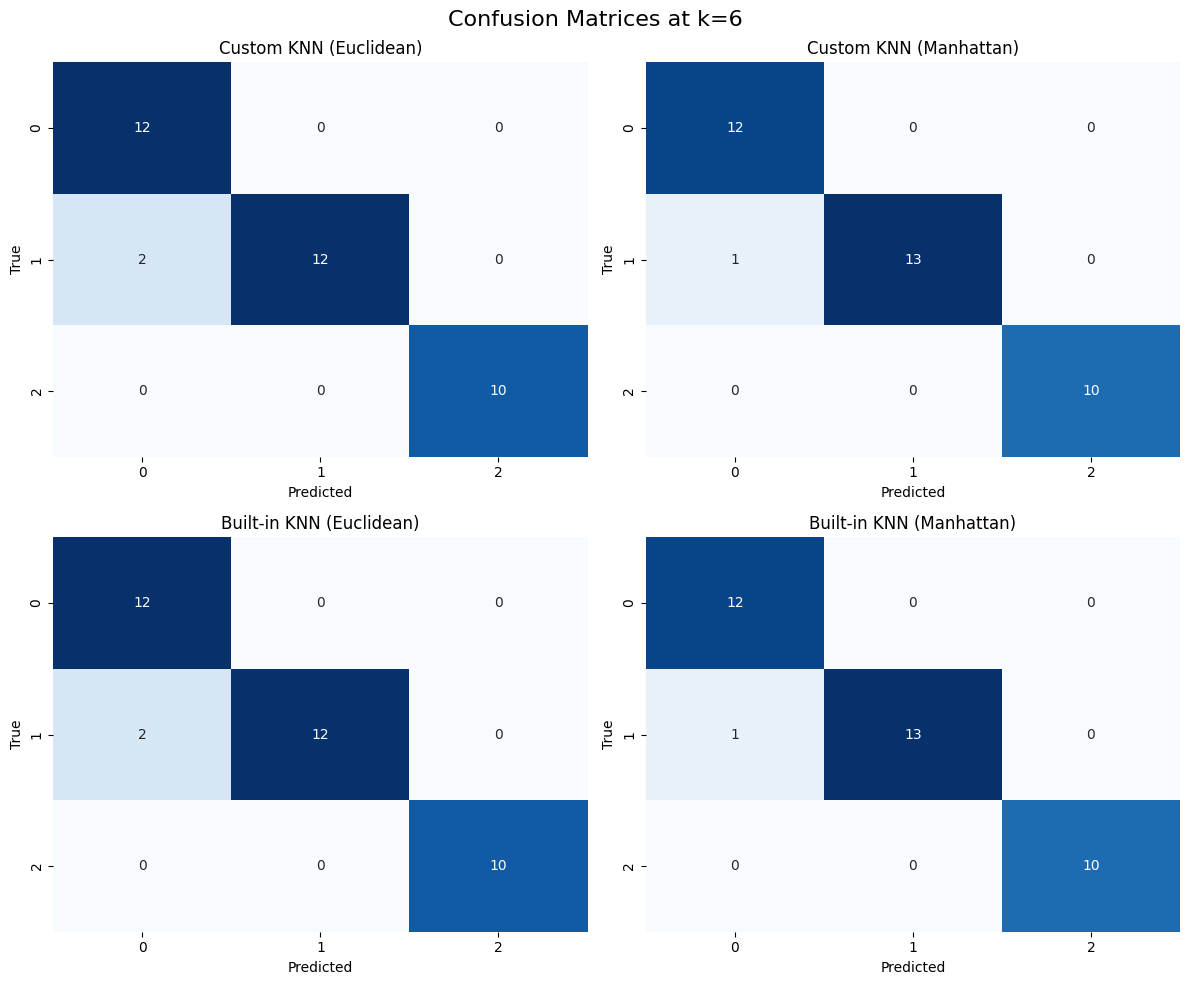


--- k=7, Custom Euclidean ---
Classification Report:
               precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36

--- k=7, Custom Manhattan ---
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

--- k=7, Built-in Euclidean ---
Classification Report:
               precision    recall  f1-score   support

           1      

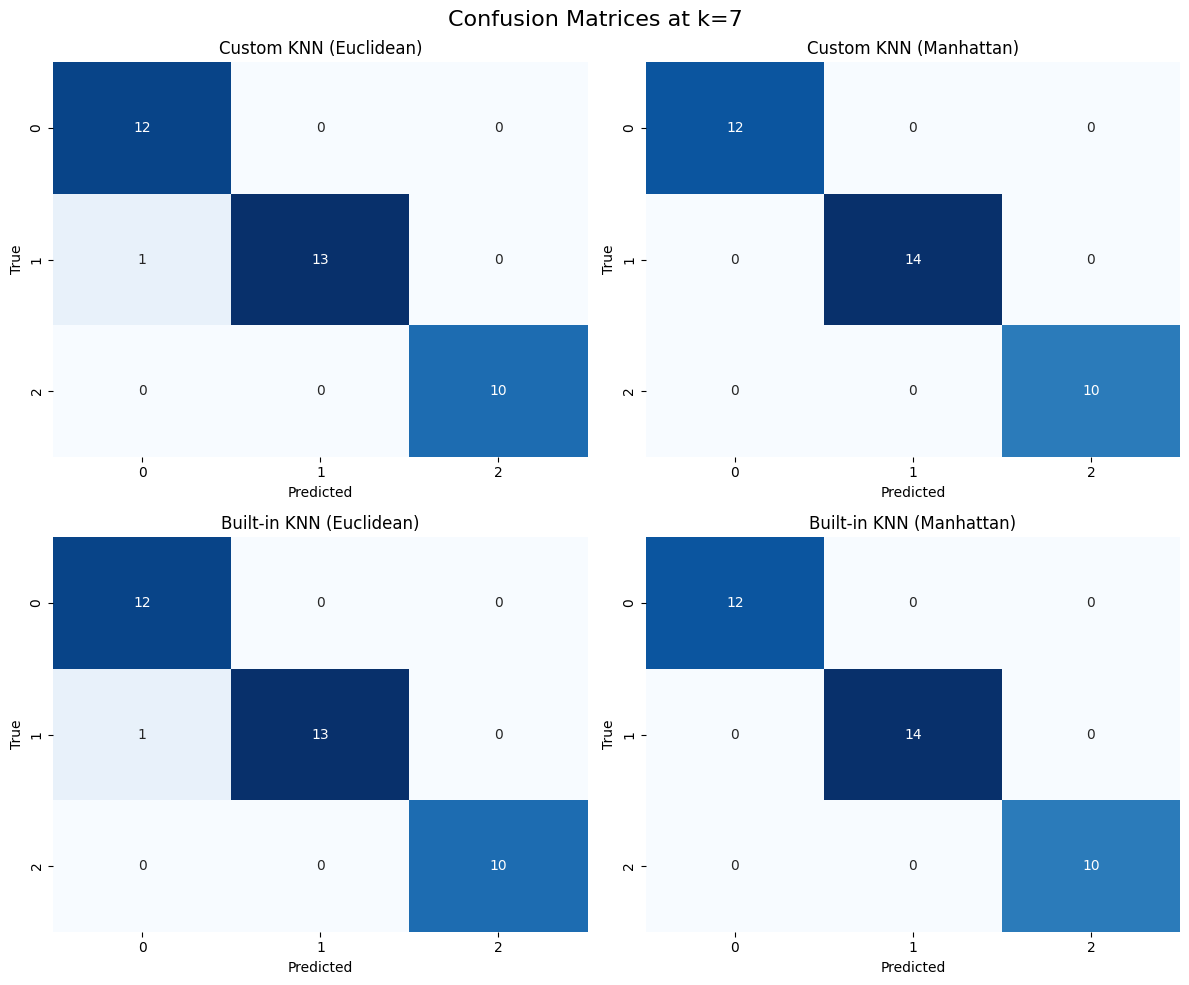

In [51]:
for k in k_values:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Confusion Matrices at k={k}", fontsize=16)

    # ----- (1) Custom Euclidean -----
    y_pred_cE = knn_predict(X_train, y_train, X_test, k, 'euclidean')
    cm_cE = confusion_matrix(y_test, y_pred_cE)
    sns.heatmap(cm_cE, annot=True, fmt='d', cmap='Blues', ax=axs[0][0], cbar=False)
    axs[0][0].set_title("Custom KNN (Euclidean)")
    axs[0][0].set_xlabel("Predicted")
    axs[0][0].set_ylabel("True")
    print(f"\n--- k={k}, Custom Euclidean ---")
    print("Classification Report:\n", classification_report(y_test, y_pred_cE))
    # ----- (2) Custom Manhattan -----
    y_pred_cM = knn_predict(X_train, y_train, X_test, k, 'manhattan')
    cm_cM = confusion_matrix(y_test, y_pred_cM)
    sns.heatmap(cm_cM, annot=True, fmt='d', cmap='Blues', ax=axs[0][1], cbar=False)
    axs[0][1].set_title("Custom KNN (Manhattan)")
    axs[0][1].set_xlabel("Predicted")
    axs[0][1].set_ylabel("True")
    print(f"--- k={k}, Custom Manhattan ---")
    print("Classification Report:\n", classification_report(y_test, y_pred_cM))

    # ----- (3) Built-in Euclidean -----
    knn_euc = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn_euc.fit(X_train, y_train)
    y_pred_bE = knn_euc.predict(X_test)
    cm_bE = confusion_matrix(y_test, y_pred_bE)
    sns.heatmap(cm_bE, annot=True, fmt='d', cmap='Blues', ax=axs[1][0], cbar=False)
    axs[1][0].set_title("Built-in KNN (Euclidean)")
    axs[1][0].set_xlabel("Predicted")
    axs[1][0].set_ylabel("True")
    print(f"--- k={k}, Built-in Euclidean ---")
    print("Classification Report:\n", classification_report(y_test, y_pred_bE))

    # ----- (4) Built-in Manhattan -----
    knn_man = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn_man.fit(X_train, y_train)
    y_pred_bM = knn_man.predict(X_test)
    cm_bM = confusion_matrix(y_test, y_pred_bM)
    sns.heatmap(cm_bM, annot=True, fmt='d', cmap='Blues', ax=axs[1][1], cbar=False)
    axs[1][1].set_title("Built-in KNN (Manhattan)")
    axs[1][1].set_xlabel("Predicted")
    axs[1][1].set_ylabel("True")
    print(f"--- k={k}, Built-in Manhattan ---")
    print("Classification Report:\n", classification_report(y_test, y_pred_bM))

    plt.tight_layout()
    plt.show()
